In [1]:
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from util.TrainRoutine import AutoEncTrainRoutine
from util.Evaluator import Evaluator
from util.aedpmerf import AEDPMERF

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We want to use the DPMERF algorithm on time series data. But we will not work on time series directly, because it does not model the temporal relation correctly. Instead we will train an AE first and use DPMERF on the encoding space, where there is no notion of time and ordering.

In [2]:
poll = 1
emb_dim = 32
aedpmerf = AEDPMERF()

------------------------------
Initialising Autoencoder with:
RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)
Training on cuda
------------------------------


In [22]:
model_name = f"poll{poll}_lstmae_180_embed{emb_dim}.pth"
if os.path.exists(f"models/{model_name}"):
    aedpmerf.load_ae(model_name)
else:
    model, history = aedpmerf.train_ae()
    plt.plot(history["train"])
    plt.plot(history["val"])
    aedpmerf.save_ae(model_name)

loading AE model from models/poll1_lstmae_180_embed32.pth


In [24]:
enc_df = aedpmerf.encode_train_data(train_ds_path=f"data/poll{poll}_normal_train_180.csv", fname=f"data/poll{poll}_normal_training_encoded_embed{emb_dim}.csv")
aedpmerf.train_gen(data=enc_df, mini_batch_size=0.1, lr=1e-3)
n_gen_samples = enc_df.shape[0]
gen_data = aedpmerf.generate(n_gen_samples, fname=f"poll{poll}_enc_gen_embed{emb_dim}.csv")
pd.DataFrame(gen_data).to_csv(f"data/generated/poll{poll}_normal_train_180_embed{emb_dim}_merf.csv")

saving encoded training data in data/poll1_normal_training_encoded_embed32.csv
minibatch:  6983
total number of datapoints in the training data is 69818
random freq (1000, 32)
Starting Training
epoch # and running loss are  [0, 6.442764699459076]
epoch # and running loss are  [100, 0.00292377921869047]
epoch # and running loss are  [200, 0.0018567825754871592]
epoch # and running loss are  [300, 0.0015953813126543537]
epoch # and running loss are  [400, 0.0014248627703636885]
epoch # and running loss are  [500, 0.0014412124583031982]
epoch # and running loss are  [600, 0.0011769725897465833]
epoch # and running loss are  [700, 0.001501971564721316]
epoch # and running loss are  [800, 0.0014688733863295056]
epoch # and running loss are  [900, 0.0012794825161108747]
epoch # and running loss are  [1000, 0.0014596870678360574]
epoch # and running loss are  [1100, 0.0011519596373545937]
epoch # and running loss are  [1200, 0.0010005956355598755]
epoch # and running loss are  [1300, 0.001141

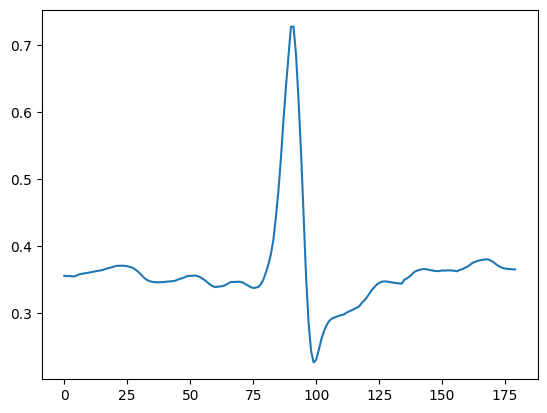

In [25]:
plt.plot(gen_data[3])

In [3]:
ae_gen = AutoEncTrainRoutine()

------------------------------
Initialising Autoencoder with:
RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)
Training on cuda
------------------------------


In [4]:
model_name = f"poll{poll}_dpmerf_embed{emb_dim}.pth"
if os.path.exists(f"models/{model_name}"):
    ae_gen.load_model(model_name)
else:
    model, history = ae_gen.train_model(train_ds_path=f"data/generated/poll{poll}_normal_train_180_embed{emb_dim}_merf.csv", val_ds_path=f"data/poll{poll}_normal_val_180.csv")
    plt.plot(history["train"])
    plt.plot(history["val"])
    ae_gen.save_model(model_name)

loading AE model from models/poll1_dpmerf_embed32.pth


In [29]:
pd.DataFrame(history["train"]).to_csv(f"loss_history/poll{poll}_merf_train.csv")
pd.DataFrame(history["val"]).to_csv(f"loss_history/poll{poll}_merf_val.csv")

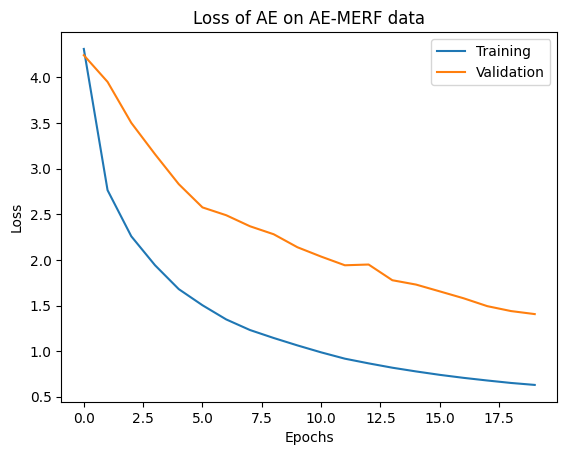

In [30]:
plt.plot(history["train"])
plt.plot(history["val"])
plt.title("Loss of AE on AE-MERF data")
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [5]:
window_size=180
evaluator = Evaluator(val_normal_path=f"data/normal_val_{window_size}.csv",
                      val_anomaly_path=f"data/anomaly_val_{window_size}.csv",
                        test_normal_path=f"data/normal_test{window_size}.csv",
                        test_anomaly_path=f"data/anomalie_test{window_size}.csv", 
                        model=ae_gen.model)

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([180, 1])) that is different to the input size (torch.Size([1, 180, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


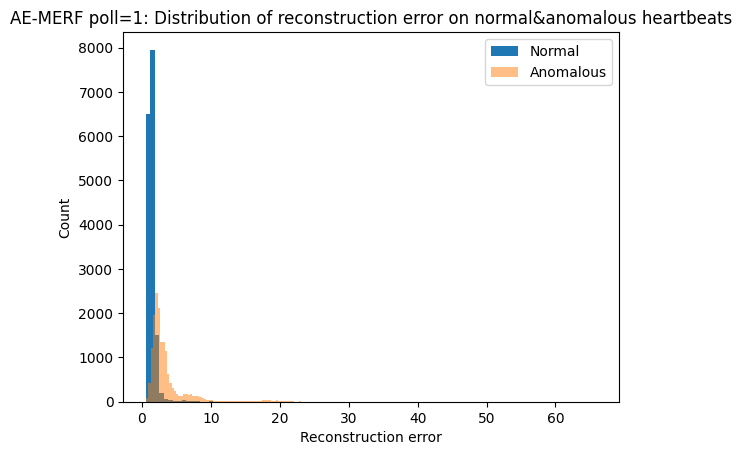

In [6]:
plt.figure()

plt.hist(evaluator.loss_val_normal, bins=100)

plt.title(f"AE-MERF poll={poll}: Distribution of reconstruction error on normal&anomalous heartbeats")

plt.hist(evaluator.loss_val_anomaly, bins=100, alpha=0.5)
plt.xlabel("Reconstruction error")
plt.ylabel("Count")

plt.legend(["Normal", "Anomalous"])

plt.show()

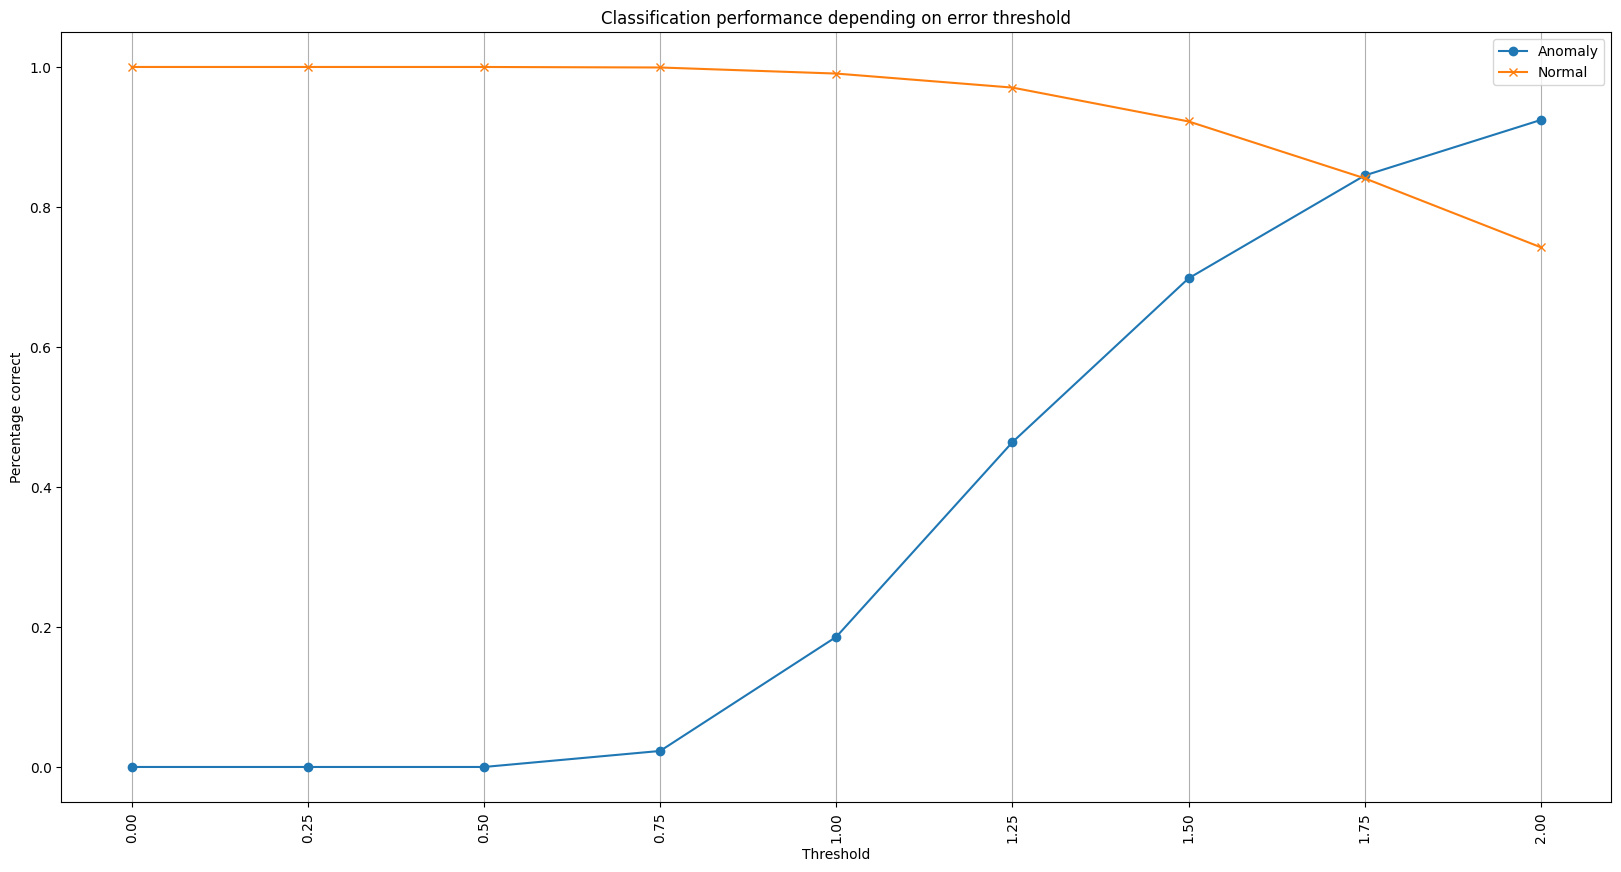

In [7]:
thres_l = np.linspace(0,2,9)
plt.figure(figsize=(20,10))
corr_normal, corr_anomaly = evaluator.find_threshold(thres_l)
plt.plot(thres_l, corr_normal, marker="o")
plt.plot(thres_l, corr_anomaly, marker="x")
plt.xlabel("Threshold")
plt.ylabel("Percentage correct")
plt.xticks(thres_l, rotation=90)
plt.legend(["Anomaly", "Normal"])
plt.title("Classification performance depending on error threshold")
plt.grid(axis="x")
plt.show()

In [8]:
predictions_normal, predictions_anomaly = evaluator.predict_class(1.75)


In [9]:
evaluator.evaluate(predictions_normal, predictions_anomaly)

TP: 1513
FN: 247
FP: 295
TN: 1509
Acc: 0.8479236812570146
Precision: 0.8593394077448747
Recall: 0.8364745011086474
F1: 0.847752808988764
Formatted (acc, prec, rec, f1):
0.8479236812570146,0.8593394077448747, 0.8364745011086474, 0.847752808988764
